In [20]:
from pypropagate import * 
from pypropagate import np,pc,presets,propagators,plot
import matplotlib.pyplot as plt
from pypropagate.colormaps import ice_colormap
from pypropagate.plot import get_metric_prefix,get_unitless_bounds
from matplotlib.colors import LogNorm
from matplotlib.ticker import FuncFormatter
import warnings
from pypropagate.progressbar import ProgressBar
from analytical_waveguides import analytical_circular_waveguide,analytical_slab_waveguide
from scipy.interpolate import RectBivariateSpline
%matplotlib inline

In [21]:
# Define gaussian beam settings
gaussian_settings = presets.settings.create_paraxial_wave_equation_settings()
s = gaussian_settings.symbols
r = pc.sqrt(s.x**2+s.y**2)
g = gaussian_settings.create_category('gaussian',info='Parameters of the gaussian beam')
g.create_symbol('w_0',type=pc.Types.Real,positive=True,info = 'Waist size at z = 0')
g.create_function('w_r',(s.z,),pc.sqrt(2)*pc.sqrt((g.w_0)**2/2-2j/(2*s.k)*s.z),info = 'Waist size')
g.create_function('u3D',(s.x,s.y,s.z),(g.w_0)**2/g.w_r**2*pc.exp(-(r**2)/(g.w_r**2)),info='3D Gaussian')
g.create_function('u2D',(s.x,s.y,s.z), (g.w_0)/g.w_r*pc.exp(-(s.x**2)/(g.w_r**2)),info='2D Gaussian')
g.w_0 = 0.25*units.um
s.n = 1
s.u_boundary = 0
gaussian_settings.wave_equation.set_energy(12*units.keV)
s.xmin = s.ymin = -10*units.um
s.xmax = s.ymax = 10*units.um
s.zmin = -10*units.mm
s.zmax = 10*units.mm    
s.Nx = s.Ny = 2**11
s.Nz = 100

In [22]:
# Define waveguide settings
waveguide_settings = presets.settings.create_paraxial_wave_equation_settings(fresnel_compatible = True)
s = waveguide_settings.symbols
wg = waveguide_settings.create_category('waveguide')
wg.create_symbol('n_1')
wg.create_symbol('n_2')
wg.create_symbol('r')
wg.create_symbol('l')
s.n = pc.piecewise((wg.n_1,s.x**2+s.y**2<=wg.r**2),(wg.n_2,True))
wg.n_1 = 1
wg.n_2 = presets.medium.create_material('Ge',waveguide_settings)
wg.r = 25*units.nm
wg.l = 0.6*units.mm
waveguide_settings.wave_equation.set_energy(12*units.keV)
s.u0 = pc.exp(-(s.x**2 + s.y**2) / (2 * (2*wg.r)**2)) 
s.u_boundary = 0
s.xmin = s.ymin = -5*wg.r
s.xmax = s.ymax = 5*wg.r
s.zmin = 0
s.zmax = 1 * units.mm

In [23]:
step_count = 100

def determine_errors(Propagator,settings,analytical_solution,N,display_progress = False):
    step_values = np.round(10**(np.linspace(1,N,step_count,dtype=float)))[::-1]

    analytical_differences = []
        
    for i in ProgressBar(step_values):
        s = settings.symbols
        s.Nz = i
        propagator = Propagator(settings)
        
        if propagator.ndim == 2:
            field = propagator.run_slice(display_progress=display_progress)[:,0,::]
        else:
            field = propagator.run_slice(display_progress=display_progress)[:,::]
        
        analytical = analytical_solution(settings)
        
        difference = abs(analytical - field[:,analytical.bounds[1][0]:])
        analytical_differences += [difference.max() / abs(analytical).max()]
        
        if display_progress: 
            plot(field)
            plot(difference)
            print difference.max() / abs(analytical).max()
        
    return step_values,analytical_differences

In [24]:
propagators_2D = [propagators.FiniteDifferences2D,propagators.Fresnel2D]
propagators_2D_names = ["Finite Differences 2D","Fresnel 2D"]

propagators_3D = [propagators.FiniteDifferences3D,propagators.Fresnel3D,propagators.FiniteDifferencesCS,propagators.FresnelCS]
propagators_3D_names = ["Finite Differences 3D","Fresnel 3D","Finite Differences CS","Fresnel CS"]

In [25]:
s = gaussian_settings.symbols
s.Nx = s.Ny = 2**14
s.u0 = g.u2D

try:
    results_gauss_2D = np.load('gauss_2D.npy')
except:
    results_gauss_2D = []

    for Propagator in propagators_2D:
        results_gauss_2D += [determine_errors(Propagator,gaussian_settings,lambda settings:expression_to_array(s.u0,settings),4)]
        
    np.save('gauss_2D.npy',results_gauss_2D)

In [26]:
s = gaussian_settings.symbols
s.Nx = s.Ny = 2**11
s.u0 = g.u3D

try:
    results_gauss_3D = np.load('gauss_3D.npy')
except:
    results_gauss_3D = []

    for Propagator in propagators_3D:
        results_gauss_3D += [determine_errors(Propagator,gaussian_settings,lambda settings:expression_to_array(s.u0.subs(s.y,0),settings),4)]        
    
    np.save('gauss_3D.npy',results_gauss_3D)

In [27]:
s = waveguide_settings.symbols
s.Nx = s.Ny = 2**14

try:
    results_wg_2D = np.load('wg_2D.npy')
except:
    results_wg_2D = []

    for Propagator in propagators_2D:
        results_wg_2D += [determine_errors(Propagator,waveguide_settings,lambda settings:analytical_slab_waveguide(settings)[:,s.sz/2:],4)]    
    
    np.save('wg_2D.npy',results_wg_2D)

In [28]:
s = waveguide_settings.symbols
s.Nx = s.Ny = 2**11

try:
    results_wg_3D = np.load('wg_3D.npy')
except:
    results_wg_3D = []

    for Propagator in propagators_3D:
        results_wg_3D += [determine_errors(Propagator,waveguide_settings,lambda settings:analytical_circular_waveguide(settings)[:,s.sz/2:],4)]
    
    np.save('wg_3D.npy',results_wg_3D)

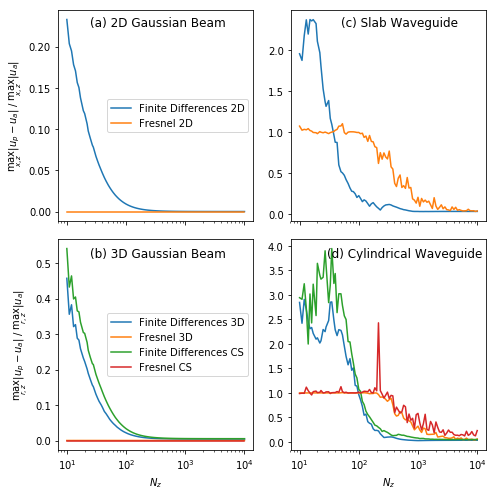

In [29]:
fig,axes = plt.subplots(2,2,figsize=(7,7),sharex=True)

# 2D Gaussian
ax = axes[0][0]
for (x,y),name in zip(results_gauss_2D,propagators_2D_names):
    ax.semilogx(x,y,label=name)
#ax.set_xlabel('$N_z$')
ax.set_ylabel('$\max_{x,z} |u_p - u_a| \; / \; \max_{x,z} |u_a|$')
ax.legend(loc=5)
fig.text(0.32,0.94,'(a) 2D Gaussian Beam',fontsize=12,horizontalalignment='center')

# 3D Gaussian
ax = axes[1][0] 
for (x,y),name in zip(results_gauss_3D,propagators_3D_names):
    ax.semilogx(x,y,label=name)
ax.set_xlabel('$N_z$')
ax.set_ylabel('$\max_{r,z} |u_p - u_a| \; / \; \max_{r,z} |u_a|$')
ax.legend(loc=5)
fig.text(0.32,0.48,'(b) 3D Gaussian Beam',fontsize=12,horizontalalignment='center')

# 2D WG
ax = axes[0][1] 
for (x,a),name in zip(results_wg_2D,propagators_2D_names):
    ax.semilogx(x,a,label=name)
#ax.set_xlabel('$N_z$')
fig.text(0.8,0.94,'(c) Slab Waveguide',fontsize=12,horizontalalignment='center')

# 3D WG
ax = axes[1][1] 
for (x,y),name in zip(results_wg_3D,propagators_3D_names):
    ax.semilogx(x,y,label=name)
ax.set_xlabel('$N_z$')
fig.text(0.81,0.48,'(d) Cylindrical Waveguide',fontsize=12,horizontalalignment='center')

plt.tight_layout()
plt.savefig('propagator_comparison_errors.pdf',transparent=True)

plt.show()